In [3]:
!pip install imageio-ffmpeg

   ---------------------------------------- 0.0/31.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/31.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/31.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/31.2 MB ? eta -:--:--
    --------------------------------------- 0.5/31.2 MB 837.5 kB/s eta 0:00:37
   - -------------------------------------- 0.8/31.2 MB 907.1 kB/s eta 0:00:34
   - -------------------------------------- 1.0/31.2 MB 1.0 MB/s eta 0:00:30
   -- ------------------------------------- 1.6/31.2 MB 1.2 MB/s eta 0:00:25
   -- ------------------------------------- 1.8/31.2 MB 1.2 MB/s eta 0:00:24
   -- ------------------------------------- 2.1/31.2 MB 1.2 MB/s eta 0:00:24
   --- ------------------------------------ 2.4/31.2 MB 1.3 MB/s eta 0:00:24
   --- ------------------------------------ 2.6/31.2 MB 1.3 MB/s eta 0:00:23
   ---- ----------------------------------- 3.1/31.2 MB 1.3 MB/s eta 0:00:21
   ---- ---------------

In [2]:
!pip install imageio natsort


   ---------------------------------------- 0/2 [natsort]
   ---------------------------------------- 0/2 [natsort]
   ---------------------------------------- 0/2 [natsort]
   ---------------------------------------- 0/2 [natsort]
   -------------------- ------------------- 1/2 [imageio]
   -------------------- ------------------- 1/2 [imageio]
   -------------------- ------------------- 1/2 [imageio]
   -------------------- ------------------- 1/2 [imageio]
   -------------------- ------------------- 1/2 [imageio]
   -------------------- ------------------- 1/2 [imageio]
   -------------------- ------------------- 1/2 [imageio]
   -------------------- ------------------- 1/2 [imageio]
   -------------------- ------------------- 1/2 [imageio]
   -------------------- ------------------- 1/2 [imageio]
   -------------------- ------------------- 1/2 [imageio]
   -------------------- ------------------- 1/2 [imageio]
   -------------------- ------------------- 1/2 [imageio]
   ----------

In [1]:
import imageio
import os
from natsort import natsorted

# Obtener lista de imágenes PNG generadas por el simulador
image_folder = '.'  # Carpeta actual
image_files = [f for f in os.listdir(image_folder) if f.startswith('vel.') and f.endswith('.png')]
image_files = natsorted(image_files)  # Orden natural: vel.0000.png, vel.0001.png, ...

# Crear el video
output_filename = 'video_flow.mp4'
fps = 20  # Fotogramas por segundo

with imageio.get_writer(output_filename, fps=fps) as writer:
    for filename in image_files:
        image_path = os.path.join(image_folder, filename)
        image = imageio.imread(image_path)
        writer.append_data(image)

print(f"✅ Video guardado como: {output_filename}")


C:\Users\al\AppData\Local\Temp\ipykernel_17740\186493122.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


✅ Video guardado como: video_flow.mp4


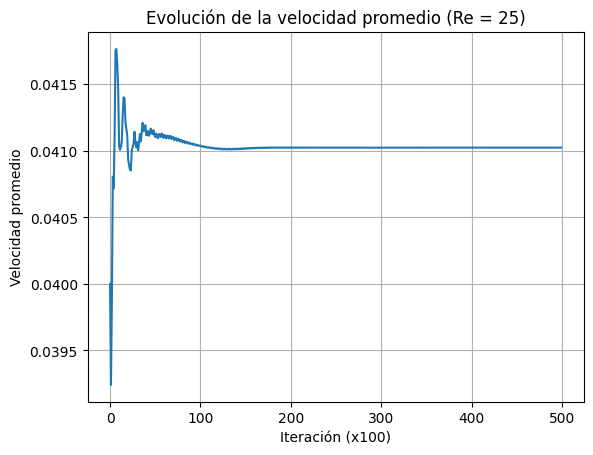

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de simulación # Ver si se estabiliza con estos valores
maxIter = 50000
Re = 25  # Cambiar este valor para testear diferentes Reynolds
nx, ny = 420, 180
ly = ny-1
cx, cy, r = nx//4, ny//2, ny//9
uLB = 0.04
nulb = uLB*r/Re
omega = 1 / (3*nulb + 0.5)

# Lattice
v = np.array([[1,1],[1,0],[1,-1],[0,1],[0,0],[0,-1],[-1,1],[-1,0],[-1,-1]])
t = np.array([1/36,1/9,1/36,1/9,4/9,1/9,1/36,1/9,1/36])
col1, col2, col3 = [0,1,2], [3,4,5], [6,7,8]

# Funciones
def macroscopic(fin):
    rho = np.sum(fin, axis=0)
    u = np.zeros((2, nx, ny))
    for i in range(9):
        u[0] += v[i,0] * fin[i]
        u[1] += v[i,1] * fin[i]
    u /= rho
    return rho, u

def equilibrium(rho, u):
    usqr = 3/2 * (u[0]**2 + u[1]**2)
    feq = np.zeros((9,nx,ny))
    for i in range(9):
        cu = 3 * (v[i,0]*u[0] + v[i,1]*u[1])
        feq[i] = rho * t[i] * (1 + cu + 0.5*cu**2 - usqr)
    return feq

# Geometría
def obstacle_fun(x,y): return (x-cx)**2 + (y-cy)**2 < r**2
obstacle = np.fromfunction(obstacle_fun, (nx, ny))

def inivel(d, x, y):
    return (1 - d) * uLB * (1 + 1e-4*np.sin(y/ly*2*np.pi))

vel = np.fromfunction(inivel, (2,nx,ny))
fin = equilibrium(1, vel)

# Seguimiento del flujo
avg_u_history = []

# Bucle principal
for time in range(maxIter):
    fin[col3, -1, :] = fin[col3, -2, :]  # outflow

    rho, u = macroscopic(fin)

    # Entrada (inflow)
    u[:,0,:] = vel[:,0,:]
    rho[0,:] = 1 / (1 - u[0,0,:]) * (np.sum(fin[col2,0,:], axis=0) + 2*np.sum(fin[col3,0,:], axis=0))
    feq = equilibrium(rho, u)
    fin[col1,0,:] = feq[col1,0,:] + fin[col3[::-1],0,:] - feq[col3[::-1],0,:]

    fout = fin - omega * (fin - feq)

    for i in range(9):
        fout[i, obstacle] = fin[8-i, obstacle]

    for i in range(9):
        fin[i] = np.roll(np.roll(fout[i], v[i,0], axis=0), v[i,1], axis=1)

    # Guardar velocidad promedio cada 100 pasos
    if time % 100 == 0:
        norm_u = np.sqrt(u[0]**2 + u[1]**2)
        avg_u = np.mean(norm_u)
        avg_u_history.append(avg_u)

# Graficar evolución de la velocidad promedio
plt.plot(avg_u_history)
plt.title(f"Evolución de la velocidad promedio (Re = {Re})")
plt.xlabel("Iteración (x100)")
plt.ylabel("Velocidad promedio")
plt.grid(True)
plt.show()
